# TP OMA 1: First order methods for large scale regression

In this pratical exercise, we will train a linear regression model using first order methods as seen in the lectures.
In general, linear regression model do not require to solve an optimization model as the solution can be derived by inverting the normal equations (if the problem has the right properties). However, in the large scale setting, the inversion of the system required in the normal equation is not possible and approximate solutions are computeed using first order methods.

Given a matrix $A\in\mathbb{R}^{n\times d}$ and $b\in\mathbb{R}^n$, we want to minimize the following objective function

$$f(x)=\frac{1}{2n}\|Ax-b\|^2=\frac{1}{2n}\displaystyle\sum_{i=1}^n(a_i^\top x -b_i)^2$$

One can see the function $f$ is $\mu$ strongly convex with $\mu=\lambda_{min}(\nabla^2 f(x))=\frac{1}{n}\lambda_{min}(A^T A)$ and $L$ smooth with $L=\lambda_{max}(\nabla^2 f(x))=\frac{1}{n}\lambda_{max}(A^T A)$, since here the Hessian matrix is constant, independent of $x$.

When $A^{T} A$ is invertible, which is the case here, then we have a simple closed form solution for (the unique) $x^* = \text{argmin}_{x \in \mathbb{R}^d} f(x)$. Indeed, solving $\nabla f(x^*) = 0$ leads to $x^* = (A^T A)^{-1} A^T b$. However when $n$ and $d$ are large (which is the case in modern "big data" problems), using this formula is prohibitively expensive from a computational viewpoint, hence the necessity of using first order optimization algorithms.

In the examples used in the following, whenever possible, in order to exhibit the convergence rates, we will also compute 𝑓(𝑥∗) using the normal equations ($𝑥^∗=(𝐴^𝑇 𝐴)^{−1}𝐴^𝑇 𝑏)$. 

Additionally, we will also consider regularized version of the least square problem in order to enforce some structure in the solution as seen in the lecture as well (ex: L1 regulatrisation for sparsity, L2 for robustness to data perturbation,...).

We will first load some useful packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import sklearn as sk
from sklearn.datasets import make_regression

## Generating data

In order to generate regression datasets, we will use a dataset generation function from the wellknown $\texttt{scikit-learn}$ machine learning python environment. The function documentation is available at  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html.

Create (by filling in the code below) a python function that will apply this function in order generate a datasets of $n$ samples of dimension $d$ (number of features).


In [2]:
def generate_dataset(n,d):
    X,Y = make_regression(n, d, n_informative=100, bias=2, coef=False, noise=10.0,random_state=1)
    return X,Y

In [3]:
n=10000
d=100

X,Y=generate_dataset(n,d)
print("X=",X)
print("Y=",Y)

A = np.c_[np.ones(n), X]

X= [[ 0.03052529 -0.20567772 -0.83449834 ...  1.65817225  0.10535739
   1.33623672]
 [ 1.02960262  0.52494273 -0.7236261  ... -0.74392899 -0.64835629
   0.69397519]
 [-1.32652038 -0.1409155   1.57631387 ...  0.02821292  1.05194479
  -0.49527154]
 ...
 [-1.00529347 -0.84683547  0.5283559  ... -0.44110834 -0.6134837
  -1.07379767]
 [-0.6028034   0.11025184 -1.86791371 ...  1.81821153  1.43920881
  -1.52556946]
 [-1.76811649  1.03101837 -1.70658571 ... -2.88009411  0.00724561
   0.22199682]]
Y= [-281.52489099 1153.16053178  848.65539179 ... -836.43682725 -119.26101168
 -708.70156442]


## Computing $f(x^*)$

In [4]:
def full_objective(Y, A, x):
    # Compute the least squares objective over the whole dataset
    n = A.shape[0]
    return 1/(2*n)*np.linalg.norm(np.dot(A, x)-Y)**2

In [5]:
x_star = np.linalg.solve(A.T@A, A.T@Y)
best_objective = full_objective(Y, A, x_star)
print("f(x*) = ", best_objective)
print(x_star)
1/max(np.linalg.eig(A.T@A)[0]/n)


f(x*) =  48.31525551451356
[ 2.01619305 73.83507344 94.99781721 96.48107092 24.89319471  8.30697283
 74.40623039 40.79776779 98.69436766  4.99361468 24.24549434 23.39434024
 53.76354506 53.94783688 72.83395556 50.87310291 36.46344928 38.61467642
 83.66359633 10.89378159 96.75122017 96.76689276 31.75709588 83.79041954
 72.18710096 91.85900723  7.44599482 67.10786677 55.30199303 91.72009339
 62.71828803 85.98827148 16.77130626 80.14988184  3.83477806  9.04546205
 29.63339715  9.43484746 10.0360945  49.33973437 84.8035762  61.06949622
 24.64261882 47.280372   85.95125489 67.82669128  4.36976313 20.23098225
  6.82055183 48.56820657 90.19221113 97.2560888  77.15897021 66.87729301
 60.9502494  42.11169889 38.79401322 63.44368564 48.31654953 17.03405167
  0.43341467 57.26165776 55.85006837 38.42388893 69.00429593 96.39417459
 56.46640799  6.86393504 74.56725653 72.38320899 62.05327222 88.94619169
 55.59180534 67.39915118 14.87147618 90.90911719 15.52032528 97.77160143
 42.17002945 54.03459003

0.8277603184217

## Gradient descent

Let us first define the gradient function that will be used next in the descent algorithm.

In [6]:
def gradient_regression(Y, A, x):
    """
    Compute the gradient of the regression function for the entire dataset.
    
    :param Y: a numpy array of shape (n)
    :param A: a numpy array of shape (n, d)
    :param x: compute the gradient at these parameters, numpy array of shape (d)
    
    :return: gradient: numpy array of shape (d)
    """
    n = A.shape[0]
    
    grad = 1/n*(A.T@(A@x - Y))
    return grad

Using your gradient function, propose an implementation of the gradient descent to solve the linear regression problem.

In [7]:
def gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        # update x through the gradient update
        x = x - lr*grad
    
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

Test now your GD on the regression problem you have generated earlier. You may try several values for the step size.

In [8]:
import datetime

# Define the parameters of the algorithm.
nmax = 1000
# lr=0.1
lr = [0.1, 0.5, 0.82]
tabObjectives = []
tabTimes = []


for lrVal in lr:
    # Initialization
    x_initial = np.zeros(A.shape[1])
    # Start GD
    start_time = datetime.datetime.now()
    gd_objectives, gd_iterates = gradient_descent(
        Y, A, x_initial, nmax, lrVal)
    end_time = datetime.datetime.now()
    tabObjectives.append(gd_objectives)
    tabTimes.append((end_time - start_time).total_seconds())
    
    # Print result
    # execution_time = (end_time - start_time).total_seconds()
    # print("GD: execution time={t:.3f} seconds".format(t=execution_time))

GD(0000/0000/9999): objective =  149908.14
GD(0001/0001/9999): objective =  120607.08
GD(0002/0002/9999): objective =   97078.70
GD(0003/0003/9999): objective =   78177.45
GD(0004/0004/9999): objective =   62986.67
GD(0005/0005/9999): objective =   50772.57
GD(0006/0006/9999): objective =   40947.48
GD(0007/0007/9999): objective =   33040.59
GD(0008/0008/9999): objective =   26674.54
GD(0009/0009/9999): objective =   21546.75
GD(0010/0010/9999): objective =   17414.49
GD(0011/0011/9999): objective =   14082.97
GD(0012/0012/9999): objective =   11395.80
GD(0013/0013/9999): objective =    9227.37
GD(0014/0014/9999): objective =    7476.73
GD(0015/0015/9999): objective =    6062.74
GD(0016/0016/9999): objective =    4920.15
GD(0017/0017/9999): objective =    3996.42
GD(0018/0018/9999): objective =    3249.31
GD(0019/0019/9999): objective =    2644.75
GD(0020/0020/9999): objective =    2155.33
GD(0021/0021/9999): objective =    1758.94
GD(0022/0022/9999): objective =    1437.75
GD(0023/002

Let us now plot the convergence profile, i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$:

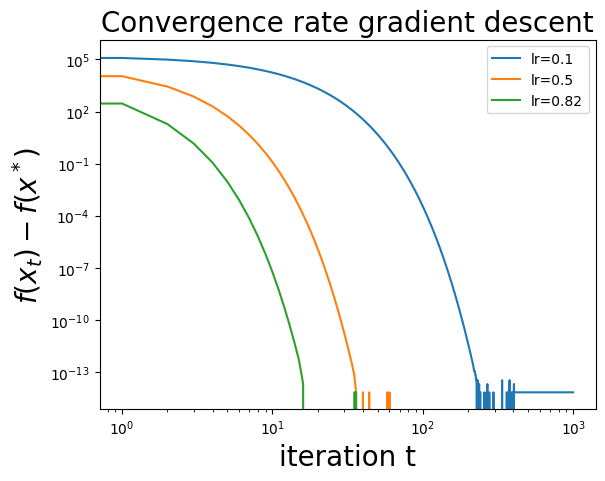

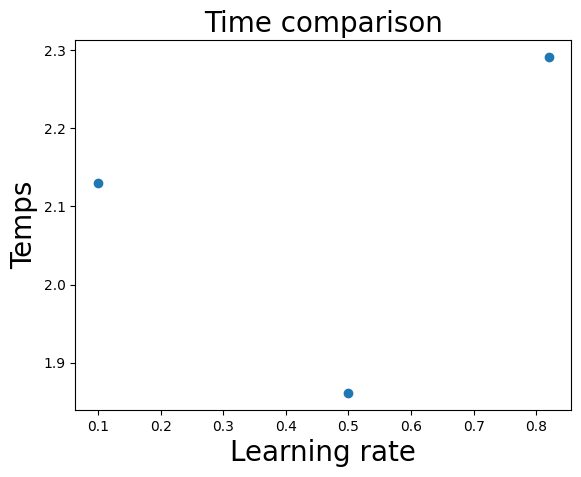

In [9]:
plt.title('Convergence rate gradient descent', fontsize = 20)
for index, gd_objectives in enumerate(tabObjectives):
    lrVal = str(lr[index])
    plt.loglog(gd_objectives - best_objective, label=f"lr={lrVal}") 
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend()
plt.show()

plt.title('Time comparison', fontsize = 20)
plt.scatter(lr, tabTimes) 
plt.xlabel('Learning rate'  , fontsize = 20)
plt.ylabel("Temps", fontsize = 20)
plt.show()

## Gradient descent acceleration

We will try now to converge faster using the gradient acceleration. Recall the acceleration scheme that adds a momentum term in the update:
$$
x_{k+1}=x_k-\alpha_k\nabla f(x_k) +\beta_k(x_k-x_{k-1})
$$
with $\alpha_k=\frac{4}{(\sqrt{L}+\sqrt{\mu})^2}$ and $\beta_k=\frac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$
and $\mu=\lambda_{min}(\nabla^2 f(x))=\frac{1}{n}\lambda_{min}(A^T A)$ and $L=\lambda_{max}(\nabla^2 f(x))=\frac{1}{n}\lambda_{max}(A^T A)$.

Based on the gradient descent function you have written above, write a new accelerated gradient function:

In [10]:
def accelerated_gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x, initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    
    x = initial_x
    n = A.shape[0]
    
    vp = np.linalg.eig(A.T@A)[0]
    u, L = min(vp)/n, max(vp)/n
    
    ak = 4/((math.sqrt(L) + math.sqrt(u))**2)
    bk = (math.sqrt(L) - math.sqrt(u))/(math.sqrt(L) + math.sqrt(u))
        
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        # update x through the accelerated gradient update
        
        x = x - ak*grad + bk*(x - xs[-2])
        
        # store x and objective
        xs.append(x.copy())
        
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

Test now your accelerated GD on the regression problem you have generated earlier.

In [11]:
import datetime

# Define the parameters of the algorithm.
nmax = 1000

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
gd_objectives_acc, gd_iterates_acc = accelerated_gradient_descent(Y, A, x_initial, nmax)
end_time = datetime.datetime.now()

# Print result
execution_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=execution_time))

GD(0000/0000/9999): objective =    1923.10
GD(0001/0001/9999): objective =    1653.96
GD(0002/0002/9999): objective =     101.99
GD(0003/0003/9999): objective =      60.38
GD(0004/0004/9999): objective =      49.13
GD(0005/0005/9999): objective =      48.42
GD(0006/0006/9999): objective =      48.32
GD(0007/0007/9999): objective =      48.32
GD(0008/0008/9999): objective =      48.32
GD(0009/0009/9999): objective =      48.32
GD(0010/0010/9999): objective =      48.32
GD(0011/0011/9999): objective =      48.32
GD(0012/0012/9999): objective =      48.32
GD(0013/0013/9999): objective =      48.32
GD(0014/0014/9999): objective =      48.32
GD(0015/0015/9999): objective =      48.32
GD(0016/0016/9999): objective =      48.32
GD(0017/0017/9999): objective =      48.32
GD(0018/0018/9999): objective =      48.32
GD(0019/0019/9999): objective =      48.32
GD(0020/0020/9999): objective =      48.32
GD(0021/0021/9999): objective =      48.32
GD(0022/0022/9999): objective =      48.32
GD(0023/002

GD(0090/0090/9999): objective =      48.32
GD(0091/0091/9999): objective =      48.32
GD(0092/0092/9999): objective =      48.32
GD(0093/0093/9999): objective =      48.32
GD(0094/0094/9999): objective =      48.32
GD(0095/0095/9999): objective =      48.32
GD(0096/0096/9999): objective =      48.32
GD(0097/0097/9999): objective =      48.32
GD(0098/0098/9999): objective =      48.32
GD(0099/0099/9999): objective =      48.32
GD(0100/0100/9999): objective =      48.32
GD(0101/0101/9999): objective =      48.32
GD(0102/0102/9999): objective =      48.32
GD(0103/0103/9999): objective =      48.32
GD(0104/0104/9999): objective =      48.32
GD(0105/0105/9999): objective =      48.32
GD(0106/0106/9999): objective =      48.32
GD(0107/0107/9999): objective =      48.32
GD(0108/0108/9999): objective =      48.32
GD(0109/0109/9999): objective =      48.32
GD(0110/0110/9999): objective =      48.32
GD(0111/0111/9999): objective =      48.32
GD(0112/0112/9999): objective =      48.32
GD(0113/011

Plot the convergence profile together with the previous plot to emphasize the acceleration, i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$:

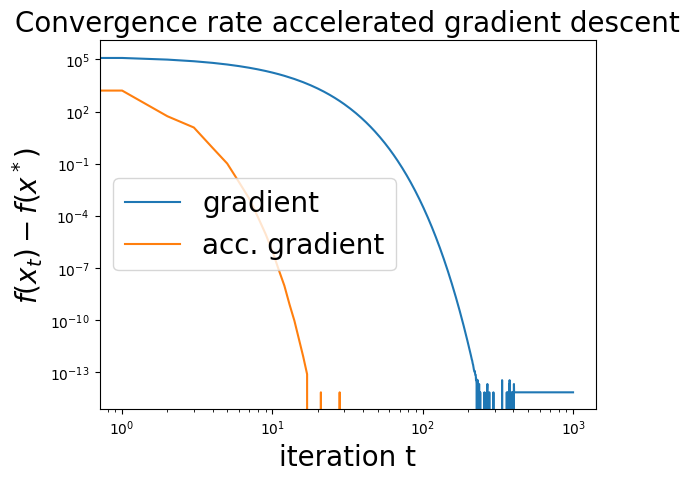

In [12]:
plt.figure(1)
plt.title('Convergence rate gradient descent', fontsize = 20)
plt.loglog(tabObjectives[0] - best_objective,label = r'gradient')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)

plt.title('Convergence rate accelerated gradient descent', fontsize = 20)
plt.loglog(gd_objectives_acc - best_objective,label = r'acc. gradient')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)

plt.legend(fontsize = 20)
plt.show()

## Subgradient descent for the $L_1$ regularized regression problem (LASSO)

Consider now the LASSO problem where we have added a $L_1$ regularization term. The problem is no longer differentiable and we propose to use a subgradient technique to solve it:

Given a matrix $A\in\mathbb{R}^{n\times d}$ and $b\in\mathbb{R}^n$, we want to minimize the following objective function

$$f(x)=\frac{1}{2n}\|Ax-b\|^2 + \lambda \|x\|_{1}$$

where $\lambda>0$ is an hyperparameter.



Write first a new routine for the objective function

In [13]:
def reg_objective(Y, A, x,lbda):
    # Compute the least squares objective over the whole dataset
    n = A.shape[0]
    return 1/(2*n)*(np.linalg.norm(A@x-Y))**2 + lbda*sum(x)

Write a subgradient function that will return a subgradient of $f$.

In [14]:
def subgradient_LASSO(Y, A, x, lbda):
    """
    Compute a subgradient of the LASSO problem for the entire dataset.
    
    :param Y: a numpy array of shape (n)
    :param A: a numpy array of shape (n, d)
    :param x: compute the gradient at these parameters, numpy array of shape (d)
    :param lbda: a positive scalar
    
    :return: subgradient: numpy array of shape (d)
    """
    n = A.shape[0]
    
    grad = 1/n*(A.T@(A@x - Y)) + lbda * np.sign(x)
    
    return grad

Using your subgradient function, propose an implementation of the subgradient descent with constant step size to solve the linear regression problem.

In [15]:
def subgradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr, lbda):
    """
    Subgradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    :param lbda: a positive scalar
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    best_obj=reg_objective(Y,A,initial_x,lbda)
    
    for epoch in range(nmax):
        subgrad = subgradient_LASSO(Y, A, x, lbda)
        
        # update x through the subgradient update
        
        x = x - lr*subgrad
    
        # store x and objective
        xs.append(x.copy())
        objective = reg_objective(Y, A, x,lbda)
        if objective<best_obj:
            best_obj=objective           
        objectives.append(best_obj)
        print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=best_obj))
    return objectives, xs

Test now your Sub-GD on the regression problem you have generated earlier. You may try several values for the step size.

In [16]:
import datetime

# Define the parameters of the algorithm.
nmax = 1000
lr=0.1
lr = np.linspace(0.1, 1, 10)
lbda=10
tabObjectivesSubG = []
tabTimes = []


for lrVal in lr:
    # Initialization
    x_initial = np.zeros(A.shape[1])
    # Start GD
    start_time = datetime.datetime.now()
    subgd_objectives, subgd_iterates = subgradient_descent(
        Y, A, x_initial, nmax, lrVal,lbda)
    end_time = datetime.datetime.now()
    
    tabObjectivesSubG.append(subgd_objectives)
    tabTimes.append((end_time - start_time).total_seconds())

# Print result
# execution_time = (end_time - start_time).total_seconds()
# print("GD: execution time={t:.3f} seconds".format(t=execution_time))

GD(0000/0000/9999): objective =  155304.11
GD(0001/0001/9999): objective =  134284.12
GD(0002/0002/9999): objective =  117395.19
GD(0003/0003/9999): objective =  103834.87
GD(0004/0004/9999): objective =   92933.79
GD(0005/0005/9999): objective =   84174.48
GD(0006/0006/9999): objective =   77113.05
GD(0007/0007/9999): objective =   71440.41
GD(0008/0008/9999): objective =   66874.40
GD(0009/0009/9999): objective =   63201.53
GD(0010/0010/9999): objective =   60238.07
GD(0011/0011/9999): objective =   57862.66
GD(0012/0012/9999): objective =   55919.40
GD(0013/0013/9999): objective =   54373.05
GD(0014/0014/9999): objective =   53144.84
GD(0015/0015/9999): objective =   52127.84
GD(0016/0016/9999): objective =   51313.99
GD(0017/0017/9999): objective =   50661.17
GD(0018/0018/9999): objective =   50118.05
GD(0019/0019/9999): objective =   49694.63
GD(0020/0020/9999): objective =   49333.92
GD(0021/0021/9999): objective =   49084.09
GD(0022/0022/9999): objective =   48818.58
GD(0023/002

Let us now plot the convergence profile, i.e. $f(x_t)$ with respect to the iteration $t$:

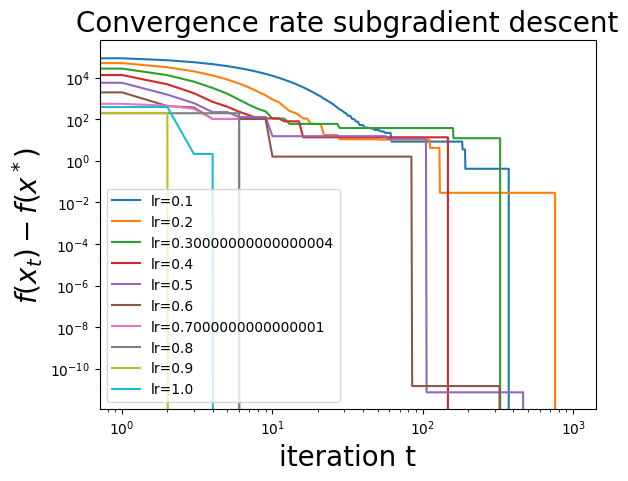

In [17]:
plt.title('Convergence rate subgradient descent', fontsize = 20)
for index, subgd_objectives in enumerate(tabObjectivesSubG):
    lrVal = str(lr[index])
    plt.loglog(subgd_objectives - subgd_objectives[nmax-1],  label=f"lr={lrVal}")
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend()
plt.show()

Propose a mean to check or visualize whether the solution of the LASSO is sparser (numerically speaking since zero coordinates may not be achieved) than the solution of the regression problem:

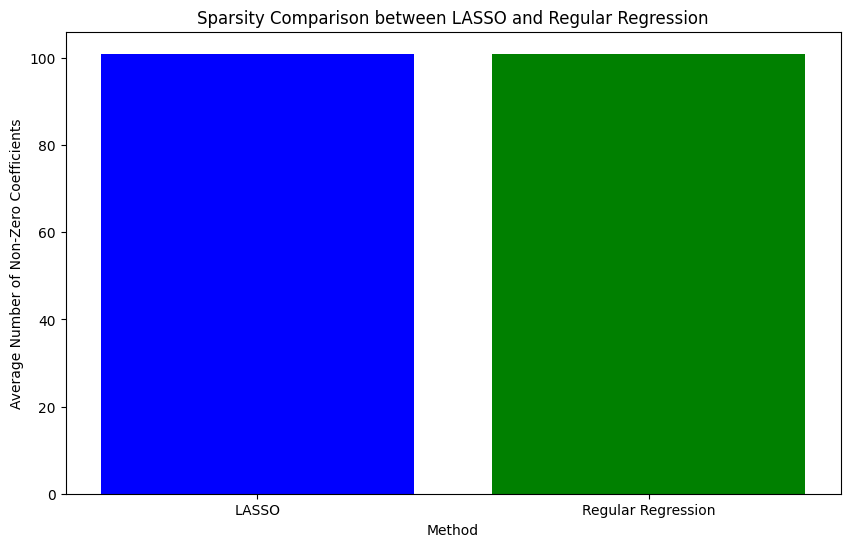

In [19]:
non_zero_counts_subgd = [np.count_nonzero(subgd_iterates[-1])]
non_zero_counts_reg = [np.count_nonzero(gd_iterates_acc[-1])]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(['LASSO', 'Regular Regression'], [np.mean(non_zero_counts_subgd), np.mean(non_zero_counts_reg)], color=['blue', 'green'])
plt.title('Sparsity Comparison between LASSO and Regular Regression')
plt.xlabel('Method')
plt.ylabel('Average Number of Non-Zero Coefficients')
plt.show()


We cannot conclude on witwh one is the sparser one here

## Proximal gradient descent for the 𝐿1 regularized regression problem (LASSO)

We will now the same problem as before using the proximal gradient algorithm specifically designed for composite functions (one smooth term and one possibly non differentiable term). We recall proximal gradient update:
$$x_{k+1}=prox_{\alpha_k h}\left\{x_k-\alpha_k \nabla g(x_k)\right\}$$
where $g$ is the function such that $g(x)=\|Ax-b\|^2$ and $h$ such that $h(x)=\lambda\|x\|_1$.

Write a prox function that will return $prox_{\alpha \lambda\|.\|_1}$. Recall that the proximal operator is given by $prox_{\alpha \lambda\|.\|}$ is such that:
$$\left(prox_{\alpha \lambda\|.\|}\right)_i=\left(\begin{array}{ll} x_i-\alpha \lambda &\mbox{if } x_i>1\\ 0 & \mbox{if } x_i \in[-\alpha\lambda,\alpha\lambda]\\ x_i+\alpha\lambda & \mbox{if } x_i>1\end{array}\right. \qquad \forall i=1,\dots,d$$.

In [130]:
def prox_L1(x,alpha):
    r = []
    for ele in x:
        if ele < alpha:
            r.append(ele + alpha)
        elif ele > alpha:
            r.append(ele - alpha)
        else:
            r.append(0)
    return r

Using your proximal operator, propose an implementation of the proximal gradient descent with constant step size to solve the linear regression problem:

In [131]:
def prox_gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr,lbda):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    :param lbda positive scalar
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        
        # update x through the gradient update
        v = x - lr*grad
        x = prox_L1(v, lr*lbda)
    
        # store x and objective
        xs.append(x.copy())
        objective = reg_objective(Y, A, x,lbda)
        objectives.append(objective)
        print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

Test now your proximal gradient method on the regression problem you have generated earlier and compare it with the subgradient method. You may try several values for the step size.

In [136]:
import datetime

# Define the parameters of the algorithm.
nmax = 1000
lr=0.1
lr = np.linspace(0.1, 1, 10)
lbda=10
tabObjectivesProx = []
tabTimesProx = []


for lrVal in lr:
    # Initialization
    x_initial = np.zeros(A.shape[1])
    # Start GD
    start_time = datetime.datetime.now()
    proxgd_objectives, proxgd_iterates = prox_gradient_descent(Y, A, x_initial, nmax, lrVal, lbda)
    end_time = datetime.datetime.now()
    tabObjectivesProx.append(proxgd_objectives)
    tabTimesProx.append((end_time - start_time).total_seconds())

# Print result
# execution_time = (end_time - start_time).total_seconds()
# print("GD: execution time={t:.3f} seconds".format(t=execution_time))

GD(0000/0000/9999): objective =  159318.31
GD(0001/0001/9999): objective =  137508.57
GD(0002/0002/9999): objective =  120013.07
GD(0003/0003/9999): objective =  105914.47
GD(0004/0004/9999): objective =   94606.01
GD(0005/0005/9999): objective =   85534.03
GD(0006/0006/9999): objective =   78195.16
GD(0007/0007/9999): objective =   72328.21
GD(0008/0008/9999): objective =   67617.37
GD(0009/0009/9999): objective =   63808.40
GD(0010/0010/9999): objective =   60728.83
GD(0011/0011/9999): objective =   58242.75
GD(0012/0012/9999): objective =   56258.41
GD(0013/0013/9999): objective =   54643.74
GD(0014/0014/9999): objective =   53349.07
GD(0015/0015/9999): objective =   52297.33
GD(0016/0016/9999): objective =   51444.95
GD(0017/0017/9999): objective =   50788.46
GD(0018/0018/9999): objective =   50233.15
GD(0019/0019/9999): objective =   49823.79
GD(0020/0020/9999): objective =   49429.82
GD(0021/0021/9999): objective =   49147.76
GD(0022/0022/9999): objective =   48895.54
GD(0023/002

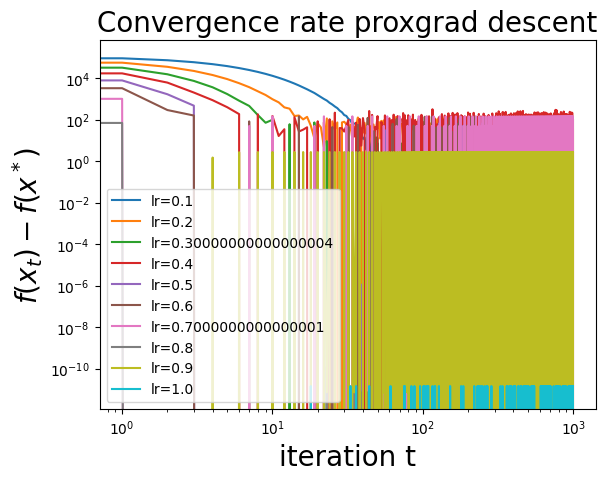

In [137]:
plt.title('Convergence rate proxgrad descent', fontsize = 20)
for index, proxgd_objectives in enumerate(tabObjectivesProx):
    lrVal = str(lr[index])
    plt.loglog(proxgd_objectives - proxgd_objectives[nmax-1],  label=f"lr={lrVal}")
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend()
plt.show()

Plot the convergence profile together with the previous plot (subgradient) and compare (i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$):

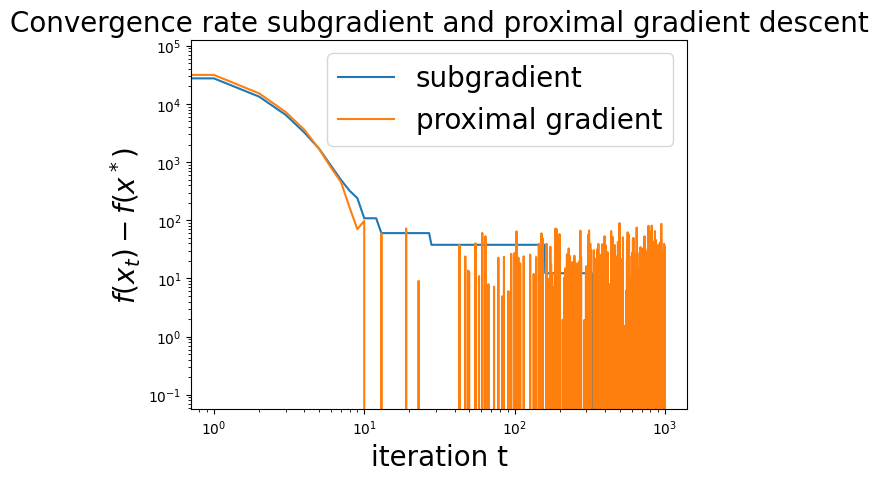

In [138]:
plt.figure(4)
plt.title('Convergence rate subgradient and proximal gradient descent', fontsize = 20)
plt.loglog(tabObjectivesSubG[2] - tabObjectivesSubG[2][nmax-1],label = r'subgradient')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)

plt.loglog(tabObjectivesProx[2] - tabObjectivesProx[2][nmax-1],label = r'proximal gradient')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()


Describe the experiments and comment the results from this notebook in your final report.